In [1]:
import sys
sys.path.append("..")
from flame_analysis_model import *
from mpi4py import MPI
import pandas as pd

In [2]:

comm = MPI.COMM_WORLD
rank = comm.rank

# Scalar names
scalars = [
    'H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
    'curvature', 'stretch_rate', 'disp_speed_density_weighted',
    'abs_flame_prop_vel_normal', 'flow_velocity_normal',
    'flow_velocity_tangential', 'tangential_strain_rate',
    'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
    'vorticity'
]

folder_name = "data/old_phi0.40_h100"
file_name = "po_premix"

# List to collect flame-front slices from all timesteps
front_list = []
timestep_start = 50
timestep_end = 124
var_name = "u" #"disp_speed_density_weighted" #"T"

for time_step in range(timestep_start, timestep_end):
    # Adjust zero padding to match your actual filenames
    print(f"Time step is now {time_step}")

    ds = SEMDataset(
        file_name=file_name,
        folder_name= folder_name,
        time_step= time_step,
        comm=MPI.COMM_WORLD,
        scalar_names=scalars
    )

    df_full = ds.create_dataframe(
        compute_vel_jacobian=False,
        compute_vel_hessian=False,
        compute_reaction_rates=False,
        cantera_inputs=["BurkeH2.yaml", None, 0.5, 300, 5e05]
    )


    # Keep only what we need for DMD
    df = df_full[["x", "y", var_name]].copy()
    df.loc[:, "timestep"] = time_step

    front_list.append(df)
    del df_full




Time step is now 50
2025-11-25 00:02:14,998 - Mesh - INFO - Initializing empty Mesh object.
2025-11-25 00:02:14,999 - Field - INFO - Initializing empty Field object
2025-11-25 00:02:15,000 - pynekread - INFO - Reading file: ./data/old_phi0.40_h100/po_premix0.f00001
2025-11-25 00:02:15,050 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-11-25 00:02:15,051 - Mesh - INFO - Initializing common attributes.
2025-11-25 00:02:15,052 - Mesh - INFO - Getting vertices
2025-11-25 00:02:15,059 - Mesh - INFO - Getting edge centers
2025-11-25 00:02:15,115 - Mesh - INFO - Facet centers not available for 2D
2025-11-25 00:02:15,116 - Mesh - INFO - Mesh object initialized.
2025-11-25 00:02:15,116 - Mesh - INFO - Mesh data is of type: float64
2025-11-25 00:02:15,116 - Mesh - INFO - Elapsed time: 0.06654139998136088s
2025-11-25 00:02:15,117 - pynekread - INFO - Reading field data
2025-11-25 00:02:15,117 - pynekread - INFO - Overwriting fld object
2025-11-25 00:02:15,721 - pynekread - INF

In [3]:
# Concatenate all timesteps into a single DataFrame
front_all = pd.concat(front_list, ignore_index=True)
del front_list
print("Unique timesteps in front_all:")
print(sorted(front_all["timestep"].unique()))

Unique timesteps in front_all:
[np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(71), np.int64(72), np.int64(73), np.int64(74), np.int64(75), np.int64(76), np.int64(77), np.int64(78), np.int64(79), np.int64(80), np.int64(81), np.int64(82), np.int64(83), np.int64(84), np.int64(85), np.int64(86), np.int64(87), np.int64(88), np.int64(89), np.int64(90), np.int64(91), np.int64(92), np.int64(93), np.int64(94), np.int64(95), np.int64(96), np.int64(97), np.int64(98), np.int64(99), np.int64(100), np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(107), np.int64(108), np.int64(109), np.int64(110), np.int64(111), np.int64(112), np.int64(113), np.int64(114), np.int64(115), np.int64(116), np.int64(117)

## DMD

In [4]:
import numpy as np


# Make sure rows are ordered by timestep and (optionally) by x,y
front_all = front_all.sort_values(["timestep", "x", "y"]).reset_index(drop=True)

# List of timesteps (sorted)
times = sorted(front_all["timestep"].unique())
n_snapshots = len(times)

# Number of spatial points (assume constant)
n_points = (front_all["timestep"] == times[0]).sum()

print("n_points:", n_points, "n_snapshots:", n_snapshots)

snapshots = []
for t in times:
    mask_t = front_all["timestep"] == t
    snap = front_all.loc[mask_t, var_name].to_numpy()
    assert len(snap) == n_points, f"Inconsistent number of points at timestep {t}"
    snapshots.append(snap)

# Snapshot matrix: shape (n_state, n_snapshots)
X = np.stack(snapshots, axis=1)
print("X shape:", X.shape)

n_points: 2737920 n_snapshots: 74
X shape: (2737920, 74)


In [5]:
from pydmd import DMD

dmd = DMD()
dmd.fit(X)


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number 2872990.756075093. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


In [6]:
print("DMD eigenvalues:", dmd.eigs)
print("modes shape:", dmd.modes.shape)
print("dynamics shape:", dmd.dynamics.shape)


DMD eigenvalues: [0.23571463+0.9018931j  0.23571463-0.9018931j  0.53424239+0.81488879j
 0.53424239-0.81488879j 0.62585822+0.74801804j 0.62585822-0.74801804j
 0.39368431+0.j         0.70333654+0.68003691j 0.70333654-0.68003691j
 0.77629208+0.59991971j 0.77629208-0.59991971j 0.83646724+0.51590747j
 0.83646724-0.51590747j 0.88368129+0.42975874j 0.88368129-0.42975874j
 0.92597407+0.34498555j 0.92597407-0.34498555j 0.96173138+0.25772411j
 0.96173138-0.25772411j 1.01399834+0.j         0.97685872+0.j
 1.00741138+0.07710342j 1.00741138-0.07710342j 0.97714404+0.16694394j
 0.97714404-0.16694394j]
modes shape: (2737920, 25)
dynamics shape: (25, 74)


## Complex plane plot

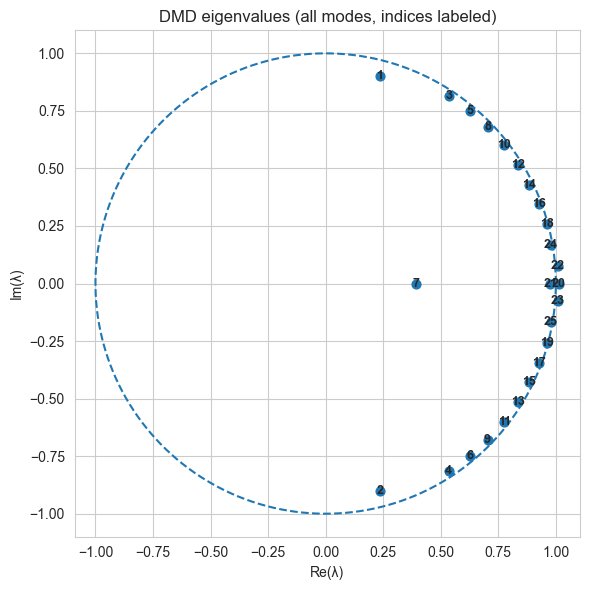

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# =========================
# 1) Complex plane: all eigenvalues
# =========================
plt.figure(figsize=(6, 6))
plt.scatter(dmd.eigs.real, dmd.eigs.imag, s=40)

# Unit circle
theta = np.linspace(0, 2 * np.pi, 200)
plt.plot(np.cos(theta), np.sin(theta), linestyle="--")

# Label each eigenvalue with its mode index (starting at 1)
for k, lam in enumerate(dmd.eigs):
    plt.text(lam.real, lam.imag, f"{k + 1}",
             ha="center", va="center",
             fontsize=9, fontweight="bold")

plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title("DMD eigenvalues (all modes, indices labeled)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()



## Plot of spatial modes

Total modes: 25
Modes used for spatial plots (one per conjugate pair): [0, 2, 4, 6, 7, 9, 11, 13, 15, 17, 19, 20, 21, 23]


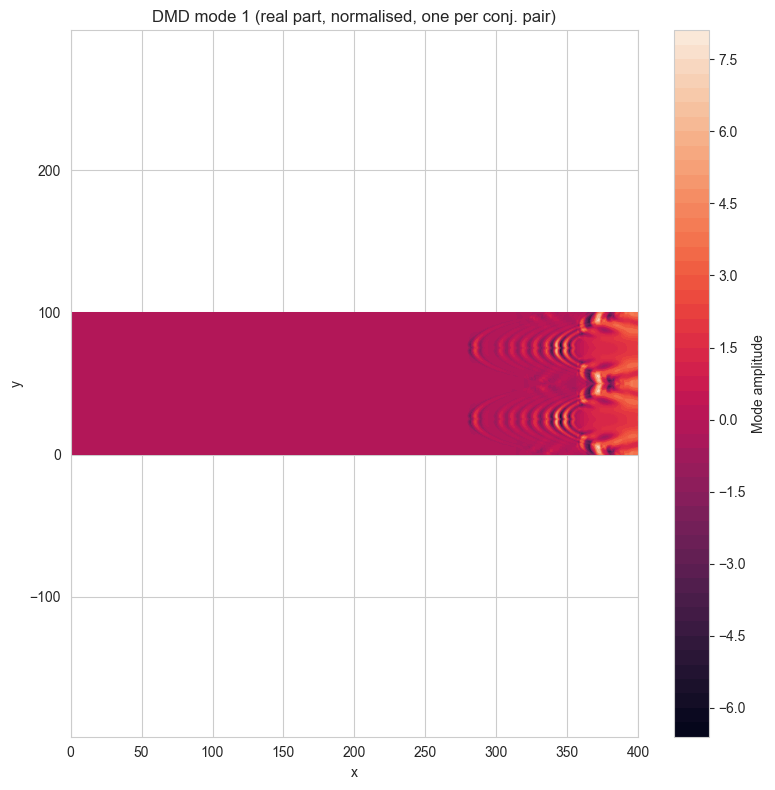

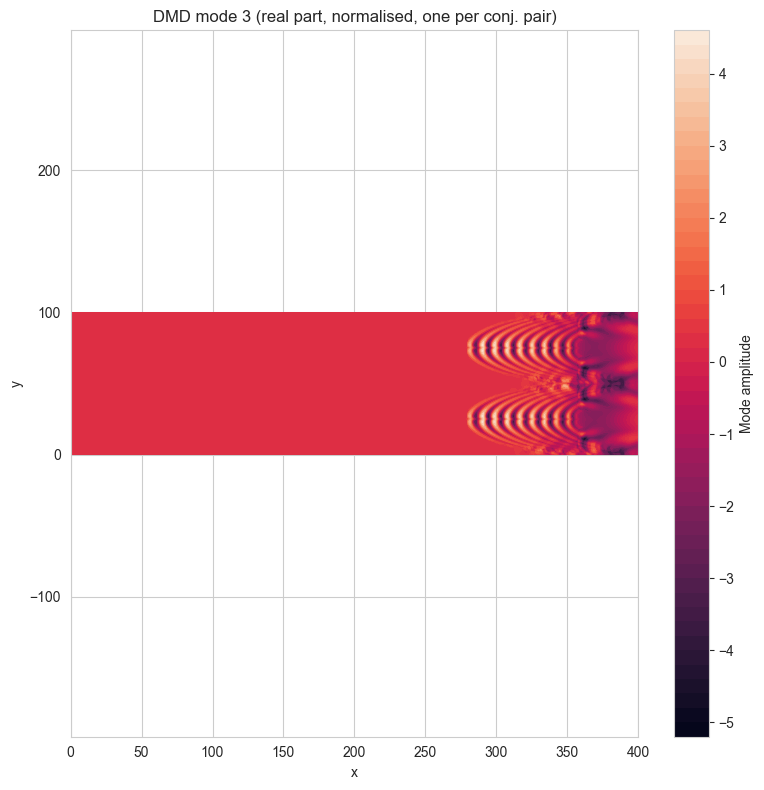

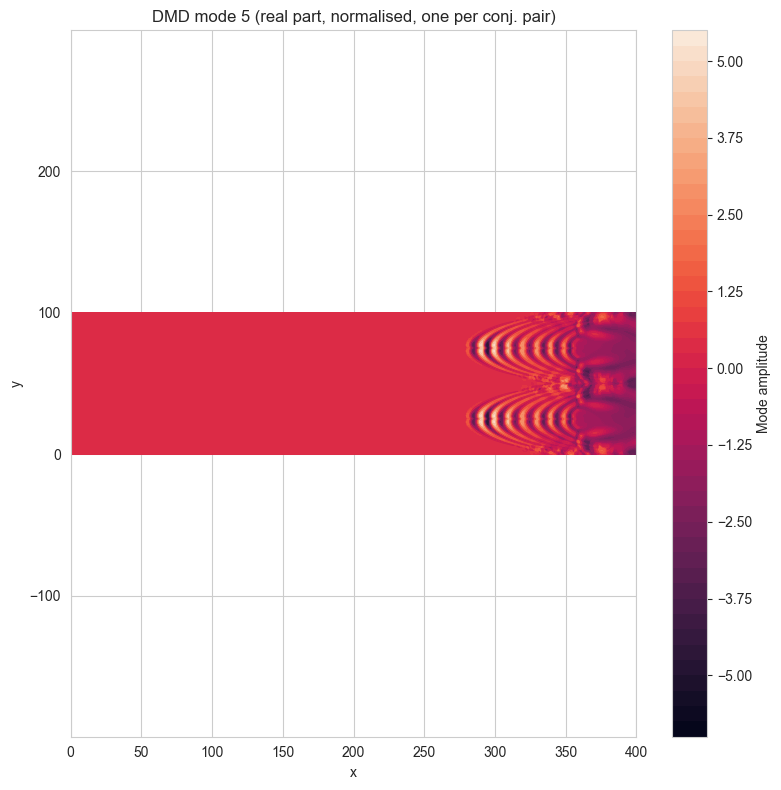

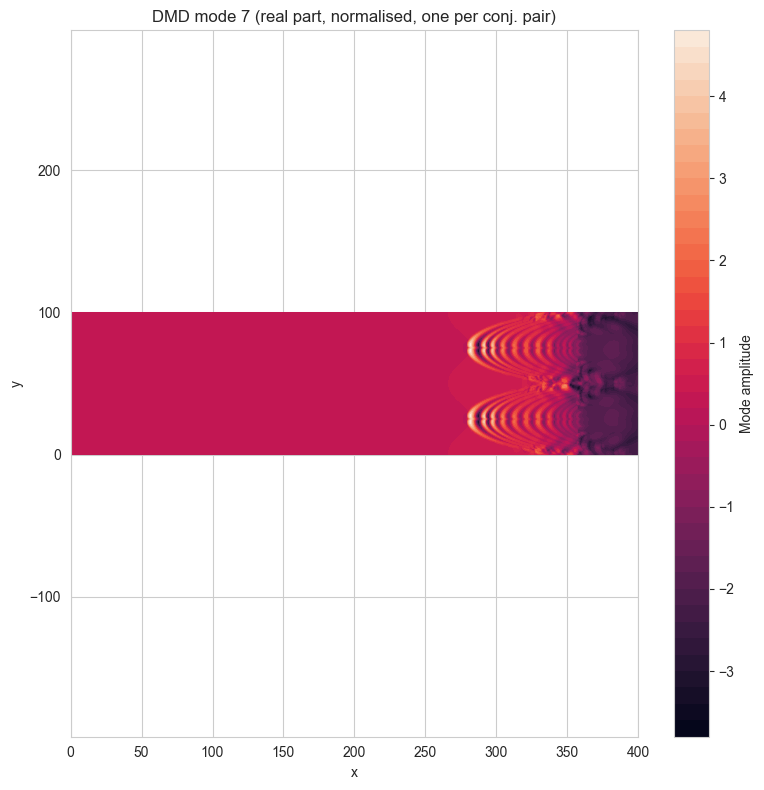

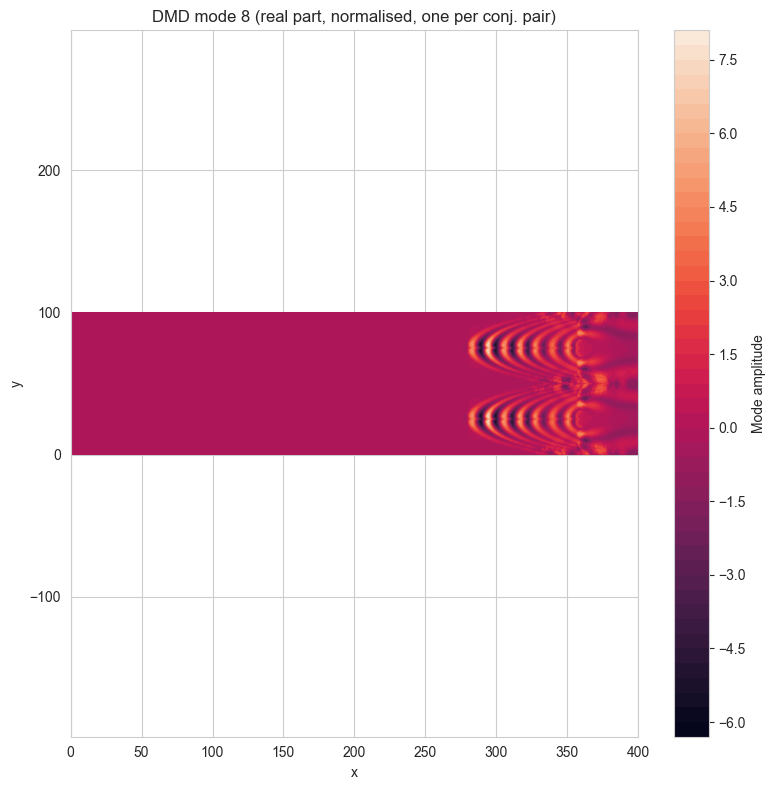

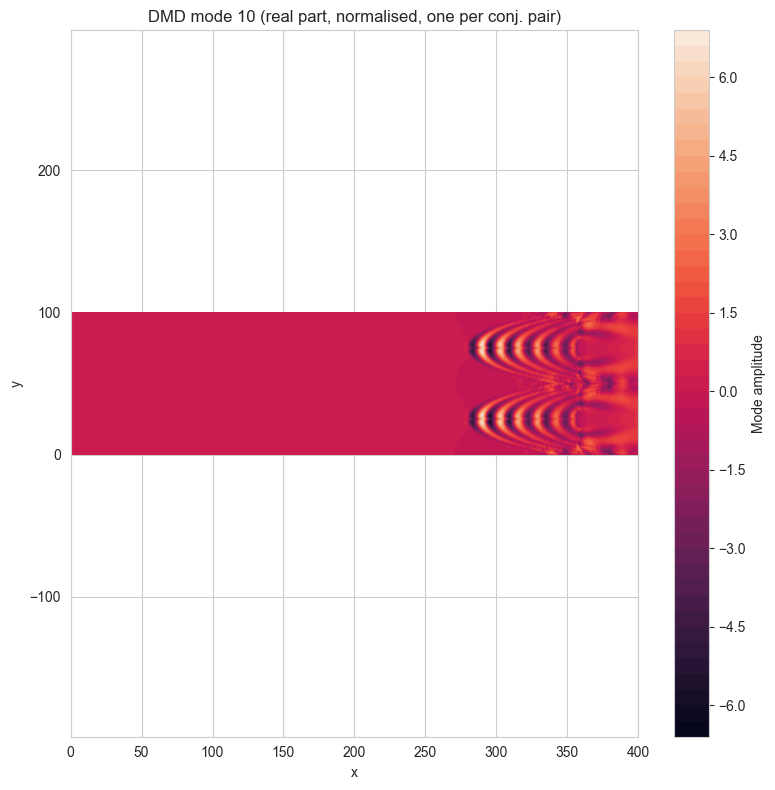

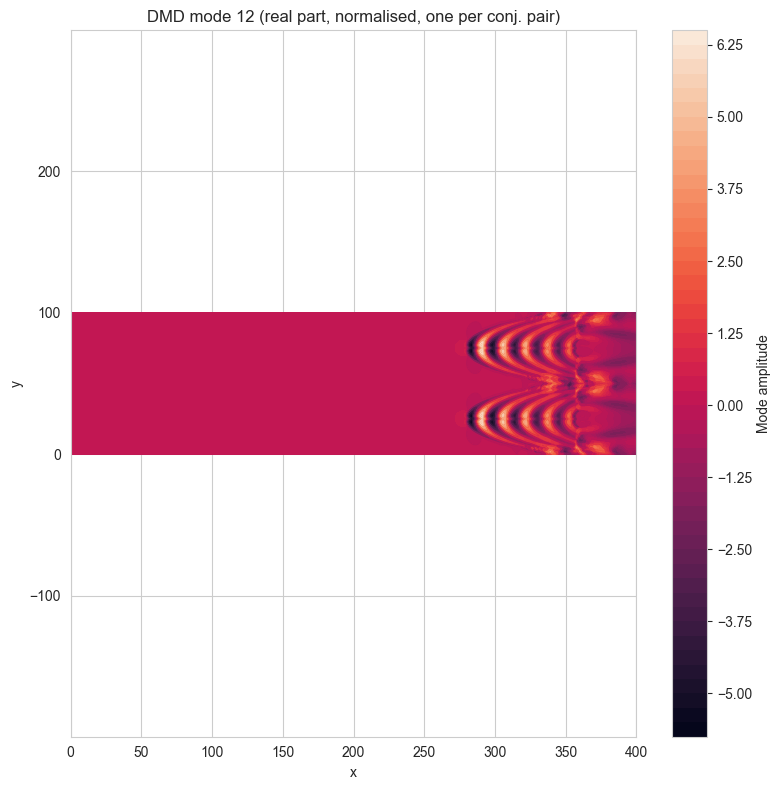

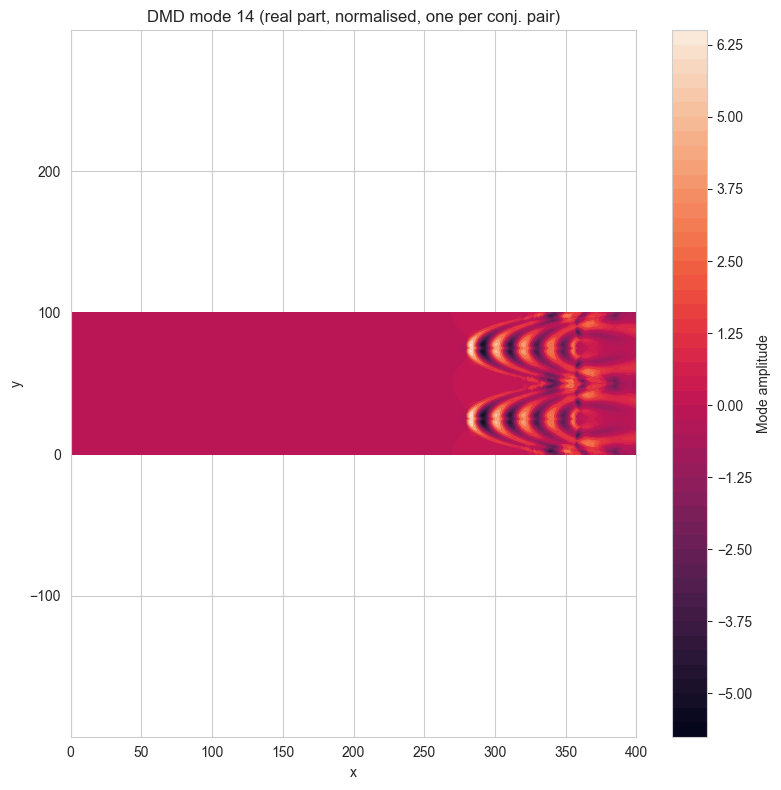

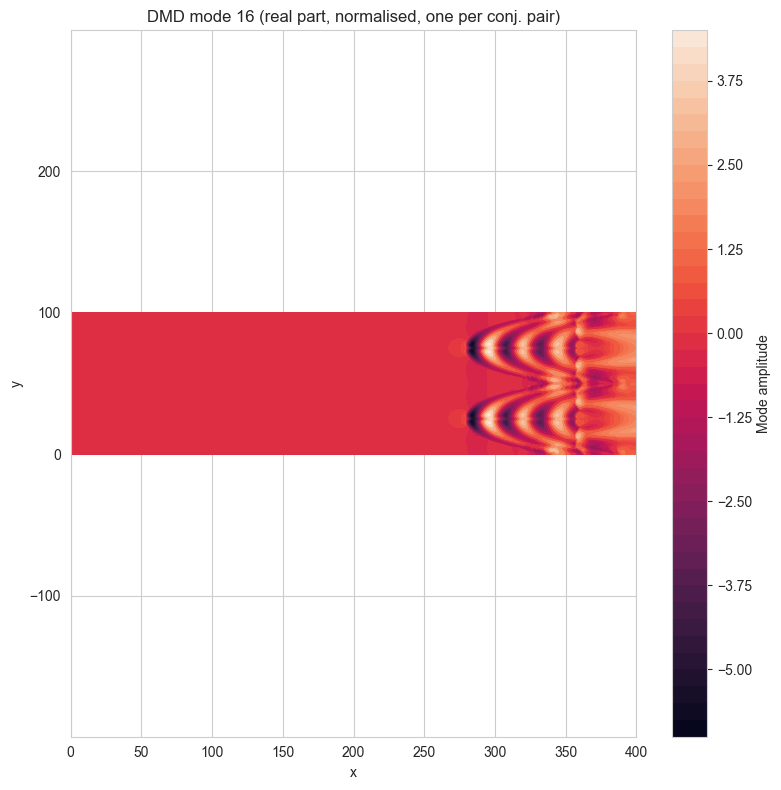

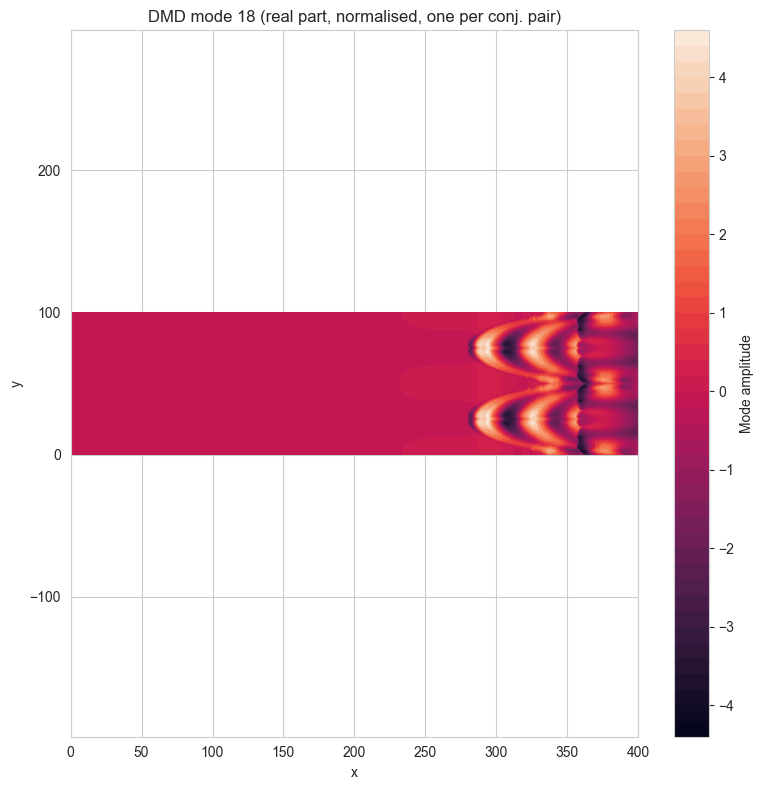

In [8]:

# =========================
# 2) Spatial modes: only one from each conjugate pair
# =========================

# Coordinates from first timestep
t0 = times[0]
mask0 = front_all["timestep"] == t0
x = front_all.loc[mask0, "x"].to_numpy()
y = front_all.loc[mask0, "y"].to_numpy()

assert dmd.modes.shape[0] == len(x) == len(y), "modes and coords misaligned!"
tri = mtri.Triangulation(x, y)

# Select mode indices: real eigenvalues + upper half-plane of complex pairs
tol = 1e-10
indices_keep = []
for i, lam in enumerate(dmd.eigs):
    if lam.imag > tol:           # strictly positive imaginary part
        indices_keep.append(i)
    elif abs(lam.imag) <= tol:   # real eigenvalue
        indices_keep.append(i)
    # if lam.imag < -tol: skip (it's the conjugate of one we already kept)

print("Total modes:", len(dmd.eigs))
print("Modes used for spatial plots (one per conjugate pair):", indices_keep)

# Plot first 5 of those
n_modes_to_plot = min(10, len(indices_keep))

for idx_plot in range(n_modes_to_plot):
    i = indices_keep[idx_plot]        # original mode index
    mode_vals = dmd.modes[:, i].real  # real part of that mode

    # optional normalisation
    mode_vals_plot = (mode_vals - mode_vals.mean()) / (mode_vals.std() + 1e-12)

    plt.figure(figsize=(8, 8))
    cf = plt.tricontourf(tri, mode_vals_plot, levels=50)
    plt.tricontour(tri, mode_vals_plot, levels=10, linewidths=0.5)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"DMD mode {i + 1} (real part, normalised, one per conj. pair)")
    plt.axis("equal")
    plt.colorbar(cf, label="Mode amplitude")
    plt.tight_layout()
    plt.show()



## Animation

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# --- modes and frames to visualise ---
modes_to_show = [0]  # only Mode 1 (0-based index)
n_modes_dyn = min(len(modes_to_show), dmd.modes.shape[1])
n_frames = dmd.dynamics.shape[1]

# --- precompute contributions of each mode at each frame ---
# fields[mi, k, :] = Re( mode_j(x,y) * dynamics_j(t_k) )
fields = np.zeros((n_modes_dyn, n_frames, dmd.modes.shape[0]))
for mi, j in enumerate(modes_to_show[:n_modes_dyn]):
    mode_j = dmd.modes[:, j]              # (n_points,)
    dyn_j = dmd.dynamics[j, :]            # (n_frames,)
    fields[mi, :, :] = (mode_j[None, :] * dyn_j[:, None]).real

# global color scale for stable animation
vmin = np.percentile(fields, 1)
vmax = np.percentile(fields, 99)

# --- create figure and axes ---
fig, axes = plt.subplots(
    1, n_modes_dyn,
    figsize=(8, 6),
    sharex=True, sharey=True
)
if n_modes_dyn == 1:
    axes = [axes]

# we'll create the colorbar lazily in the first call
cbar = None  # will hold the colorbar object

def update_frame(frame_idx):
    global cbar  # so we can assign it once and reuse it

    for mi, j in enumerate(modes_to_show[:n_modes_dyn]):
        ax = axes[mi]
        ax.clear()

        field = fields[mi, frame_idx, :]

        # filled contours + isolines
        cf = ax.tricontourf(tri, field, levels=30, vmin=vmin, vmax=vmax)
        ax.tricontour(tri, field, levels=10, linewidths=0.5)

        ax.set_aspect("equal")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        t_label = times[frame_idx]
        ax.set_title(f"Mode {j+1} contribution at t = {t_label}")

        # create colorbar only once (first frame)
        if cbar is None:
            cbar = fig.colorbar(cf, ax=ax, label="Mode contribution")
        else:
            # just update its mappable to the new contour
            cbar.update_normal(cf)

    # return a list of artists if you like, but not strictly needed with to_jshtml
    return []

# you can optionally skip frames for speed
skip = 1
frames = range(0, n_frames, skip)

ani_dmd = FuncAnimation(
    fig,
    update_frame,
    frames=frames,
    interval=300,   # ms between frames
    repeat=False
)

plt.close(fig)  # avoid static extra figure in notebook
HTML(ani_dmd.to_jshtml())


KeyboardInterrupt: 

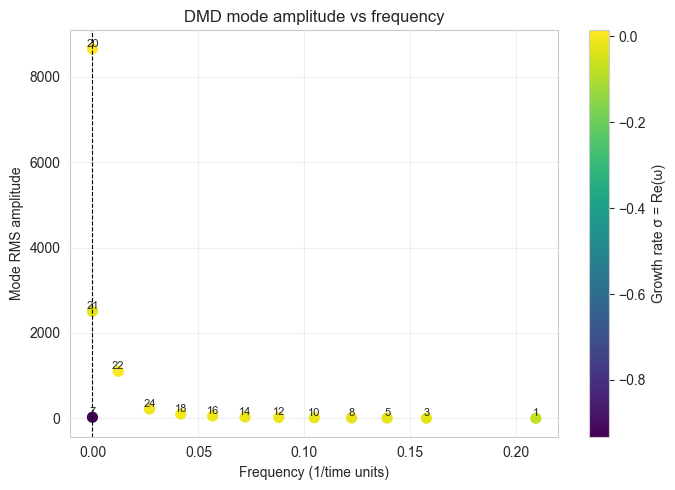

Top modes by RMS amplitude:
mode         freq        sigma      amp_rms
  20  0.00000e+00  1.39013e-02  8.65856e+03
  21  0.00000e+00 -2.34132e-02  2.50624e+03
  22  1.21574e-02  1.03044e-02  1.10033e+03
  23 -1.21574e-02  1.03044e-02  1.10033e+03
  24  2.69314e-02 -8.73549e-03  2.18711e+02
  25 -2.69314e-02 -8.73549e-03  2.18711e+02
  19 -4.16711e-02 -4.34433e-03  9.97315e+01
  18  4.16711e-02 -4.34433e-03  9.97315e+01
  17 -5.67601e-02 -1.19194e-02  5.50149e+01
  16  5.67601e-02 -1.19194e-02  5.50149e+01


In [10]:

# --- 1. Continuous-time eigenvalues and frequencies ---

dt = float(times[1] - times[0])   # physical time step between snapshots

lam = dmd.eigs                     # complex eigenvalues (discrete time)
omega = np.log(lam) / dt          # continuous-time exponents

sigma = omega.real                # growth/decay rate
freq  = omega.imag / (2 * np.pi)  # frequency (1/time units)

# --- 2. Mode amplitude measure ---

dyn = dmd.dynamics                # shape (n_modes, n_snapshots)
amp_rms = np.sqrt(np.mean(np.abs(dyn)**2, axis=1))   # RMS amplitude per mode

# --- 3. Collapse complex conjugate pairs: keep freq >= 0 ---

tol = 1e-12
idx_keep = np.where(freq >= -tol)[0]   # indices of modes to plot (≥ 0 freq)

freq_plot = freq[idx_keep]
amp_plot  = amp_rms[idx_keep]
sigma_plot = sigma[idx_keep]

# --- 4. Amplitude vs frequency plot with mode numbers ---

plt.figure(figsize=(7, 5))

sc = plt.scatter(freq_plot, amp_plot, c=sigma_plot, s=50, cmap="viridis")
plt.axvline(0.0, color="k", linewidth=0.8, linestyle="--")

# Add mode numbers (use original DMD mode index + 1 for consistency)
for j, k in enumerate(idx_keep):
    plt.text(freq_plot[j], amp_plot[j],
             f"{k+1}",            # display mode number starting at 1
             fontsize=8,
             ha="center", va="bottom")

plt.xlabel("Frequency (1/time units)")   # adapt label if dt in seconds (Hz)
plt.ylabel("Mode RMS amplitude")
plt.title("DMD mode amplitude vs frequency")

cbar = plt.colorbar(sc, label="Growth rate σ = Re(ω)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 5. Optional: print a small table of dominant modes ---

order = np.argsort(amp_rms)[::-1]

print("Top modes by RMS amplitude:")
print(f"{'mode':>4} {'freq':>12} {'sigma':>12} {'amp_rms':>12}")
for k in order[:10]:
    print(f"{k+1:4d} {freq[k]:12.5e} {sigma[k]:12.5e} {amp_rms[k]:12.5e}")

 ## DMD Observations:

- All of them have a mode on 1
- The more time steps I take the more the modes move towards 1
- Sd didn't work, might need to scale it first